In [1]:
import plotly.express as plx
import os
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

import scipy.stats as st
from scipy.stats import median_abs_deviation as mad

from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix

%matplotlib inline

In [2]:
DATA_PATH = "../data/input"

# Data loading

In [3]:
df_acq = pd.read_csv(os.path.join(DATA_PATH, 'internship_acquisition_list.csv'))
#df_acq[df_acq['class'].isin(['QC']) & (df_acq['batch'] == 1)].sort_values('order')

In [4]:
df_data = pd.read_csv(os.path.join(DATA_PATH, 'internship_data_matrix.csv'))
df_feature_meta = pd.read_csv(os.path.join(DATA_PATH, 'internship_feature_metadata.csv'))

# Augment dataset with metadata
df_data = df_data.merge(df_acq[['sample', 'class', 'order', 'batch']], on='sample')
df_data = df_data.melt(id_vars=['sample', 'class', 'order', 'batch'],value_name='intensity', var_name='feature')
df_data = df_data.merge(df_feature_meta[['feature', 'mz', 'rt']], on='feature')
df_data['feature_number'] = df_data['feature'].apply(lambda s : int(s.split('-')[1]))

# Filter classes, batch of interest and mass range of interest
df_data = df_data[df_data['class'].isin(['QC', 'Dunn', 'French', 'LMU']) & df_data['batch'] == 1]
df_glycans = df_feature_meta[df_feature_meta['mz'] > 500]
df_data = df_data.merge(df_glycans['feature'], on='feature', how='inner')

# Data processing

## 1 - Select features :
* which have a limited variability across quality check samples (CV < 30%)
* which are consistently detected across samples (70%)
* which present a D-ratio < 50% (optional)

In [5]:
df_QC = df_data[df_data['class'] == 'QC']

##  Remove features with outliers in QC to compute robust CV on features
# df_QC_summary = df_QC.groupby(['feature'])['intensity'].describe().reset_index()
# df_QC_summary['lower_bound'] = 2.5*df_QC_summary['25%'] - 1.5*df_QC_summary['75%']
# df_QC_summary['upper_bound'] = 2.5*df_QC_summary['75%'] - 1.5*df_QC_summary['25%']
# df_QC = df_QC.merge(df_QC_summary[['feature', 'lower_bound', 'upper_bound']], on='feature')
# print(f"Each QC sample has at least 1 outliers :\n{df_QC[(df_QC['intensity'] < df_QC['lower_bound']) | (df_QC['intensity'] > df_QC['upper_bound']) ].groupby('sample').size()}.")

##  Since the features first selection step relies on CV per feature, we can just remove feature with outlier value for each sample
# df_QC = df_QC[(df_QC['intensity'] >= df_QC['lower_bound']) & (df_QC['intensity'] <= df_QC['upper_bound']) ]

In [6]:
# Compute CV

cv_QC = df_QC.groupby('feature')['intensity']\
    .agg(lambda x : 1.4826 * mad(x) / x.median()).reset_index()\
    .rename(columns={'intensity' : 'CV%'})
cv_QC.describe()

,CV%
count,248.000000
mean,0.227350
std,0.170106
min,0.025969
25%,0.145458
50%,0.191384
75%,0.257509
max,1.374284


According to [Instrumental Drift in Untargeted Metabolomics: Optimizing Data Quality with Intrastudy QC Samples](https://pmc.ncbi.nlm.nih.gov/articles/PMC10222478/#sec4-metabolites-13-00665), a accepted CV threshold for biomarker discovery is 20%. This work allows 30%.

In [7]:
# Select features which exhibit limited variability in QC

selected_feats = list(cv_QC[cv_QC['CV%'] <= 0.30]['feature'])
print(f"At this stage, {len(selected_feats)} features were selected")

At this stage, 209 features were selected


In [8]:
df_data_process = df_data[df_data['feature'].isin(selected_feats)]

We select features that are consistently detected across samples.
We consider that a feature is present in a sample if its intensity is above 400 (from previous analysis in EDA). Then we select features which are present in all samples at least 70% of the time.

In [9]:
df_data_process['detection'] = df_data_process['intensity'].apply(lambda x: x >= 500)
df_detect = df_data_process.groupby('feature').agg({'detection':lambda x : x.sum() / x.size})
detected_features = df_detect.loc[df_detect['detection'] >= 0.7].index
print(f"At this stage, {len(detected_features)} features were selected")
df_data_process = df_data_process[df_data_process['feature'].isin(detected_features)]

At this stage, 175 features were selected


C:\Users\Philippine\AppData\Local\Temp\ipykernel_7856\3838521633.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data_process['detection'] = df_data_process['intensity'].apply(lambda x: x >= 500)


### D-ratio filtering, optional, not run in this notebook

In [10]:
sample_classes = ['Dunn', 'French', 'LMU']
qc_classes = ['QC']#, 'dQC']

QC_std = df_data_process[df_data_process['class'].isin(qc_classes) & (df_data_process['batch'] == 1)]\
        .groupby(['feature']).agg({'intensity':lambda x : mad(x)})\
        .rename(columns={'intensity' : 'std_QC'})
general_std = df_data_process[df_data_process['class'].isin(sample_classes)]\
        .groupby(['feature']).agg({'intensity':lambda x : mad(x) })\
        .rename(columns={'intensity' : 'std_sample'})

d_ratio = general_std.reset_index().merge(QC_std.reset_index(), on='feature', how='outer')
d_ratio['D_ratio'] = d_ratio.apply(lambda x : 100 * x.std_QC / (np.sqrt(x.std_QC**2 + x.std_sample**2)), axis=1)

In [11]:
# Compute the biological standard deviation to the technical standard deviation per feature
d_ratio['std_ratio'] = d_ratio['std_sample'] / d_ratio['std_QC']

# Select features with low D-ratio
selected_feats_dratio = d_ratio[d_ratio['D_ratio'] <= 50]['feature'].to_list()
df_data_process = df_data_process[df_data_process['feature'].isin(selected_feats_dratio)]

In [ ]:
print(f"At this stage, {len(selected_feats_dratio)} features were selected")

## 2 - Remove samples with outliers 

In [10]:
# Detect outliers

summ = df_data_process.groupby('feature')['intensity'].describe().reset_index()
summ['lower_bound'] = 2.5*summ['25%'] - 1.5*summ['75%']
summ['upper_bound'] = 2.5*summ['75%'] - 1.5*summ['25%']
df_data_process = df_data_process.merge(summ[['feature', 'lower_bound', 'upper_bound']], on='feature')
nb_outliers = df_data_process[(df_data_process['intensity'] < df_data_process['lower_bound']) | (df_data_process['intensity'] > df_data_process['upper_bound']) ]\
                .groupby(['class','sample']).size().reset_index()
nb_outliers = nb_outliers.rename(columns={0:'nb_outliers'})

Since there is at least 1 outlier per sample, we can discard samples based on a number of outliers.

In [11]:
# Filter samples

print(f"Number of samples per class before filtering :\n{df_data_process.drop_duplicates(['sample', 'class']).groupby('class').size()}")
samples_to_exclude = list(nb_outliers[(nb_outliers['nb_outliers'] > 4) & ~(nb_outliers['class'] == 'QC')]['sample'])
df_data_process = df_data_process[~df_data_process['sample'].isin(samples_to_exclude)].drop(['lower_bound', 'upper_bound'], axis=1)
print(f"Number of samples per class after filtering :\n{df_data_process.drop_duplicates(['sample', 'class']).groupby('class').size()}")

Number of samples per class before filtering :
class
Dunn      27
French    26
LMU       26
QC        11
dtype: int64
Number of samples per class after filtering :
class
Dunn      24
French    23
LMU       20
QC        11
dtype: int64


##  3- Rescale data to improve comparability

Apply log to intensity to improve comparability

In [12]:
df_data_process['log_intensity'] = df_data_process['intensity'].apply(lambda x : np.nan if x == 0.0 else np.log(x))
df_data_process['log_intensity'] = df_data_process[['feature', 'log_intensity']].groupby('feature').transform(lambda x : x.fillna(x.median()))

In [13]:
df_data_process = df_data_process[df_data_process['class'].isin(['Dunn', 'French', 'LMU'])]

## 4. Plot result

Text(0.5, 1.0, 'PCA data projection on 2 main dimensions')

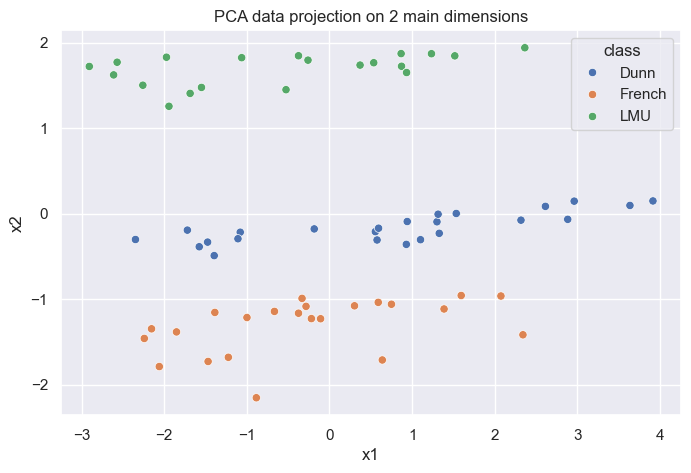

In [14]:
from sklearn.decomposition import PCA

df = df_data_process[['feature', 'log_intensity', 'sample', 'class']].groupby(['class','sample','feature']).first().unstack()
pca_2d = PCA(n_components=2)
X = df.to_numpy()
X_new = pca_2d.fit_transform(X)

sns.set(rc = {'figure.figsize':(8, 5)})
df_plot = pd.DataFrame(X_new, columns=['x1', 'x2'])
df_plot['class'] = [c for (c, i) in df.index]

fig = sns.scatterplot(df_plot, x='x1', y='x2', hue='class')
fig.set_title('PCA data projection on 2 main dimensions')

In [15]:
df_X = df_data_process[['sample','feature', 'log_intensity', 'class']].pivot(index=['sample', 'class'], columns='feature', values='log_intensity').reset_index()
X = df_X.drop(['sample', 'class'], axis=1).to_numpy()
y = df_X['class'].apply(lambda x : ['Dunn', 'French', 'LMU'].index(x)).to_numpy()

c:\Users\Philippine\Documents\Job search\Isospec\isospec-internship\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Philippine\Documents\Job search\Isospec\isospec-internship\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\Philippine\AppData\Roaming\uv\python\cpython-3.11.11-windows-x86_64-none\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Philippine\AppData\Roaming\uv\python\cpython-3.11.11-windows-x86_64-none\Lib\subprocess.py"

Text(0.5, 1.0, 't-SNE data projection on 2 main dimensions')

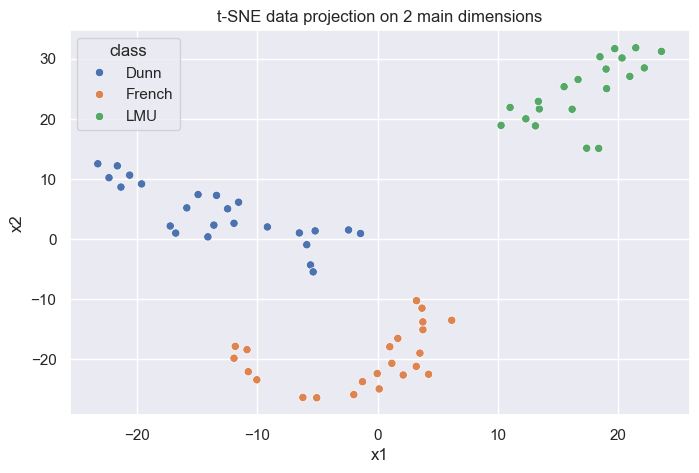

In [16]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=7).fit_transform(X)

sns.set(rc = {'figure.figsize':(8, 5)})
df_plot = pd.DataFrame(X_embedded, columns=['x1', 'x2'])
df_plot['class'] = df_X['class'].to_numpy()

fig = sns.scatterplot(df_plot, x='x1', y='x2', hue='class')
fig.set_title('t-SNE data projection on 2 main dimensions')

After feature engineering and data processing, we can see clearly 3 data clusters on PCA and t-SNE projection plots.

## 5 Final selection

In [19]:
print(f"Final curated list contains {df_data_process['feature'].nunique()} features and {df_data_process['sample'].nunique()} samples.")

Final curated list contains 175 features and 67 samples.


In [20]:
print(f"Selected features are : \n{df_data_process['feature'].unique()}\n")
print(f"Selected samples are : \n{df_data_process['sample'].unique()}")

Selected features are : 
['FT-002' 'FT-004' 'FT-005' 'FT-006' 'FT-007' 'FT-008' 'FT-009' 'FT-010'
 'FT-011' 'FT-012' 'FT-014' 'FT-015' 'FT-016' 'FT-017' 'FT-018' 'FT-019'
 'FT-020' 'FT-021' 'FT-022' 'FT-023' 'FT-024' 'FT-025' 'FT-026' 'FT-027'
 'FT-030' 'FT-031' 'FT-032' 'FT-033' 'FT-034' 'FT-035' 'FT-036' 'FT-037'
 'FT-039' 'FT-040' 'FT-041' 'FT-042' 'FT-043' 'FT-044' 'FT-045' 'FT-046'
 'FT-048' 'FT-049' 'FT-050' 'FT-052' 'FT-053' 'FT-054' 'FT-055' 'FT-056'
 'FT-057' 'FT-058' 'FT-059' 'FT-061' 'FT-062' 'FT-063' 'FT-064' 'FT-066'
 'FT-067' 'FT-069' 'FT-070' 'FT-073' 'FT-074' 'FT-075' 'FT-076' 'FT-077'
 'FT-078' 'FT-080' 'FT-081' 'FT-082' 'FT-083' 'FT-084' 'FT-085' 'FT-087'
 'FT-088' 'FT-089' 'FT-092' 'FT-093' 'FT-095' 'FT-096' 'FT-098' 'FT-099'
 'FT-100' 'FT-101' 'FT-102' 'FT-103' 'FT-104' 'FT-105' 'FT-107' 'FT-109'
 'FT-110' 'FT-111' 'FT-112' 'FT-113' 'FT-114' 'FT-117' 'FT-118' 'FT-119'
 'FT-121' 'FT-122' 'FT-123' 'FT-124' 'FT-127' 'FT-128' 'FT-129' 'FT-133'
 'FT-135' 'FT-139' 'FT-140

## 6 - Feature ranking 

In [21]:
df_X = df_data_process[['sample','feature', 'log_intensity', 'class']].pivot(index=['sample', 'class'], columns='feature', values='log_intensity').reset_index()
X = df_X.drop(['sample', 'class'], axis=1).to_numpy()
y = df_X['class'].apply(lambda x : ['Dunn', 'French', 'LMU'].index(x)).to_numpy()

### 6.1 - Mutual information 

Mutual information (MI) between two random variables is a non-negative value, which measures the dependency between the variables. It is equal to zero if and only if two random variables are independent, and higher values mean higher dependency. [See link.](https://scikit-learn.org/1.5/modules/generated/sklearn.feature_selection.mutual_info_classif.html#sklearn.feature_selection.mutual_info_classif)

Here we rank features based on their mutual information with the the target, ie. the sample class.

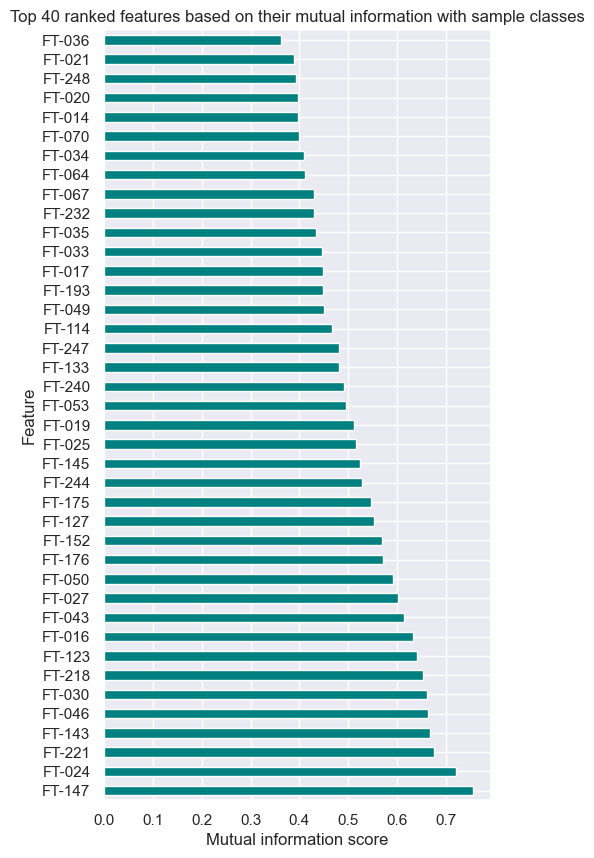

In [22]:
importances = mutual_info_classif(X, y, random_state=42)
feat_importances = pd.Series(importances, df_X.drop(['sample', 'class'], axis=1).columns)
feat_importances.sort_values(ascending=False).head(40).plot(kind='barh', color = 'teal', figsize=(5,10))
plt.xlabel('Mutual information score')
plt.ylabel('Feature')
plt.title('Top 40 ranked features based on their mutual information with sample classes')
plt.show()

### 6.2 Classification with Random Forest and features ranking

We should pay attention to overfitting, since we have a small high-dimentional dataset:
* decreasing max_depth and increasing min_samples_leaf
* setting max_features to sqrt(nb_features).

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
param_grid = {
    "n_estimators": [5, 10, 15, 20, 25, 30],
    "max_depth": [3],
    "max_features":['sqrt'],
    "bootstrap": [True]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, n_jobs=-1, scoring='balanced_accuracy')
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")
print(f"Best score: {grid_search.best_score_}")

Best parameters: {'bootstrap': True, 'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 10}
Best score: 0.9629629629629631


In [25]:
best_model = RandomForestClassifier(**best_params, random_state=42, oob_score=True)
best_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, n_estimators=10, oob_score=True,
                       random_state=42)

In [26]:
y_pred = best_model.predict(X_test)
print('Classification report :\n', classification_report(y_test, y_pred,\
                                                        target_names=['Dunn', 'French', 'LMU']))
print('Confusion matrix :\n', confusion_matrix(y_test, y_pred))

Classification report :
               precision    recall  f1-score   support

        Dunn       0.86      1.00      0.92         6
      French       1.00      0.80      0.89         5
         LMU       1.00      1.00      1.00         3

    accuracy                           0.93        14
   macro avg       0.95      0.93      0.94        14
weighted avg       0.94      0.93      0.93        14

Confusion matrix :
 [[6 0 0]
 [1 4 0]
 [0 0 3]]


In [27]:
top_n = 40
importances = best_model.feature_importances_
features = df_X.drop(['sample', 'class'], axis=1).columns
feat_importances_rf = pd.Series(importances, features)

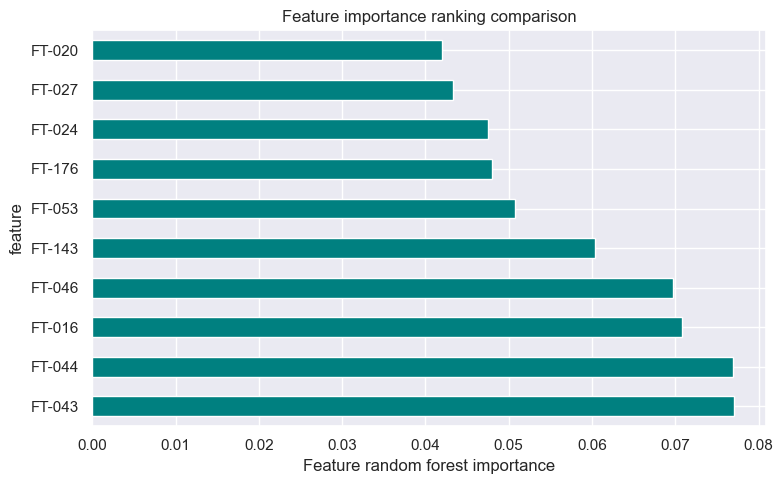

In [28]:
feat_importances_rf.sort_values(ascending=False).head(10).plot(kind='barh', color = 'teal')
plt.xlabel('Feature random forest importance')
plt.title('Feature importance ranking comparison')
#plt.plot(figsize=(7,10))
plt.tight_layout()
plt.savefig(os.path.join('../output', 'feature_importance.png'))

### 6.3 Features importance visualisation

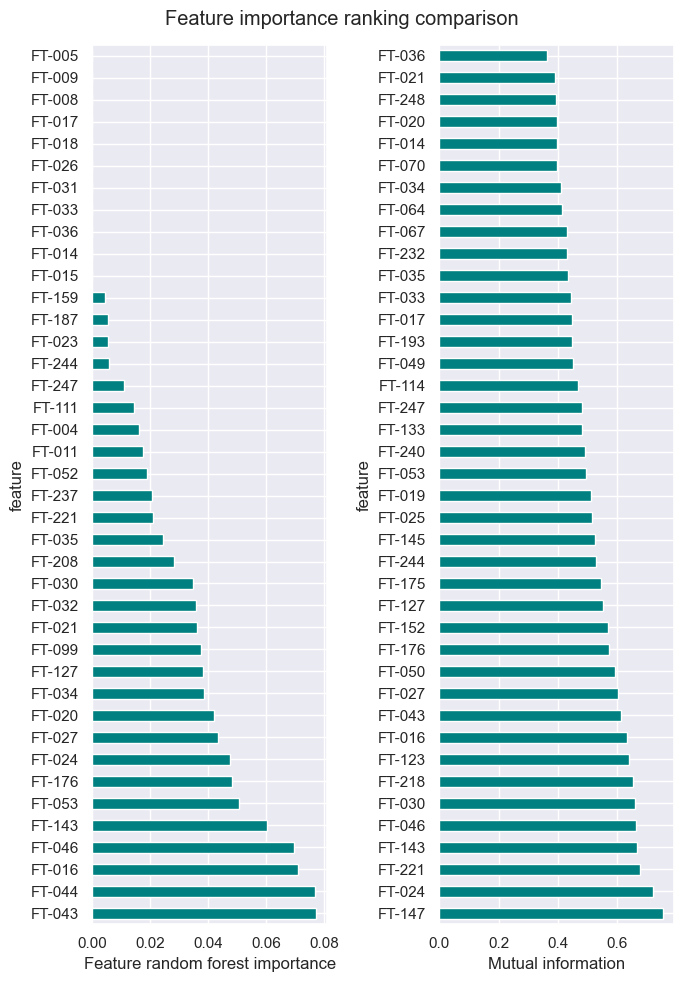

In [29]:
fig, axs = plt.subplots(ncols=2, figsize=(7,10))
feat_importances_rf.sort_values(ascending=False).head(40).plot(kind='barh', color = 'teal', ax=axs[0])
axs[0].set_xlabel('Feature random forest importance')
feat_importances.sort_values(ascending=False).head(40).plot(kind='barh', color = 'teal', ax=axs[1])
axs[1].set_xlabel('Mutual information')
plt.suptitle('Feature importance ranking comparison')
plt.tight_layout()

We end up with an accuracy of 0.93 on the test dataset, with precisions (fraction of relevant instances among retrieved instances) of 1 for French (Lung cancer) and LMU (Benign disease), and .86 for Dunn (Healthy). 

Below we plot the top-10 features intensity distributions for the three classes and the two methods.

In [30]:
feat_importances_rf.sort_values(ascending=False).head(10).index

Index(['FT-043', 'FT-044', 'FT-016', 'FT-046', 'FT-143', 'FT-053', 'FT-176',
       'FT-024', 'FT-027', 'FT-020'],
      dtype='object', name='feature')

Text(0.5, 1.0, 'Random-Forest-top-10 discriminative features distribution')

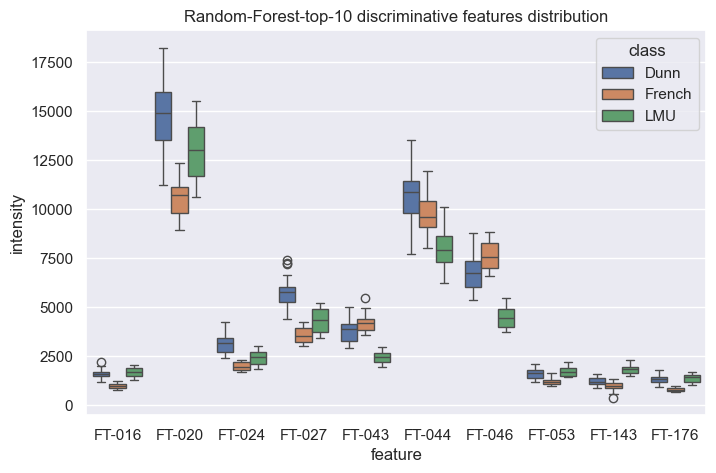

In [31]:
top_10 = feat_importances_rf.sort_values(ascending=False).head(10).index.to_list()
fig = sns.boxplot(df_data_process[df_data_process['feature'].isin(top_10)], x='feature', y='intensity', hue='class')
fig.set_title('Random-Forest-top-10 discriminative features distribution')

Assuming normal distribution, independent samples and equal variance, from above plots :

In [32]:
from scipy.stats import ttest_ind

p_val = 0.05/3 # Because we have multiple comparisons
print(f"Multiple comparison pvalue = {p_val}")

for feat in top_10:
    a = df_data_process[(df_data_process['feature'] == feat) & (df_data_process['class'] == 'Dunn')]['intensity']
    b = df_data_process[(df_data_process['feature'] == feat) & (df_data_process['class'] == 'French')]['intensity']
    c = df_data_process[(df_data_process['feature'] == feat) & (df_data_process['class'] == 'LMU')]['intensity']
    test_1 = ttest_ind(a,b)
    test_2 = ttest_ind(a,c)
    test_3 = ttest_ind(b,c)

    print(f"For feature {feat}:\n")
    print(f"p-value when performing Student t test between Dunn & French = {test_1.pvalue}\n")
    print(f"p-value when performing Student t test between Dunn & LMU = {test_2.pvalue}\n")
    print(f"p-value when performing Student t test between LMU & French = {test_3.pvalue}\n")
    print("-"*60, '\n')

    

Multiple comparison pvalue = 0.016666666666666666
For feature FT-043:

p-value when performing Student t test between Dunn & French = 0.009783094874742913

p-value when performing Student t test between Dunn & LMU = 3.0743321596559296e-12

p-value when performing Student t test between LMU & French = 9.725796025271942e-18

------------------------------------------------------------ 

For feature FT-044:

p-value when performing Student t test between Dunn & French = 0.008244082388617301

p-value when performing Student t test between Dunn & LMU = 1.6461837293968675e-09

p-value when performing Student t test between LMU & French = 5.922370955137451e-07

------------------------------------------------------------ 

For feature FT-016:

p-value when performing Student t test between Dunn & French = 1.821674057470278e-14

p-value when performing Student t test between Dunn & LMU = 0.3654970134147839

p-value when performing Student t test between LMU & French = 6.900283730821276e-16

--

After t-test, we can assess at the 95% confidence level for features 16, 53 and 176, intensities mean are distinct between Lung cancer and Healthy groups and between Lung cancer and benign disease groups while the difference is not statistically significant between the benign disease and the healthy group.

For all the features that are left, feature mean intensity is different across the three classes.

Text(0.5, 1.0, 'Mutual-information-top-5 discriminative features distribution')

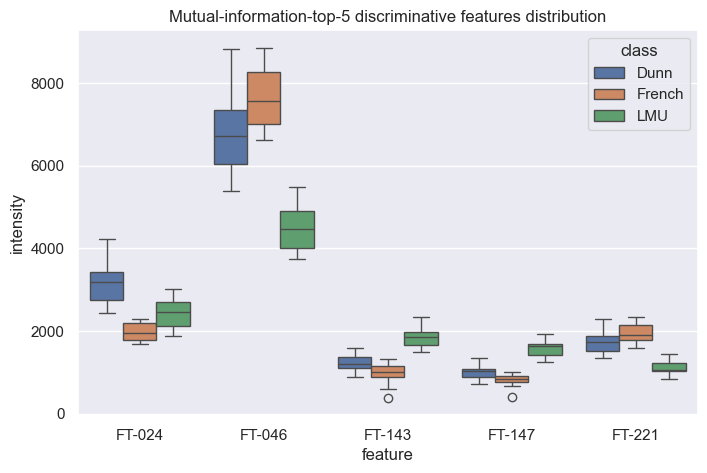

In [33]:
fig = sns.boxplot(df_data_process[df_data_process['feature_number'].isin([147, 24, 221,143,46])], x='feature', y='intensity', hue='class')
fig.set_title('Mutual-information-top-5 discriminative features distribution')

### 6.4 Next steps

This was a general discriminative feature ranking. We could in further steps implement shapley values on random forest prediction to see the most important features in a class-wise prediction manner.